In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Open the dataset and drop Unnamed: 32 and id features

In [3]:
path_folder = '/content/drive/MyDrive/Datasets/SI_final_project'
PATH = os.path.join(path_folder, 'breast_cancer_wisconsin.csv')

bcw_df = pd.read_csv(PATH)
bcw_df = bcw_df.drop(['id', 'Unnamed: 32'], axis=1)
target, bcw_df = bcw_df['diagnosis'], bcw_df.drop('diagnosis', axis=1)
bcw_df['target'] = target
bcw_df['target'] = bcw_df['target'].apply(lambda x: {'M': 1, 'B': 0}.get(x))

In [4]:
def to_latex(df):
  print(df.to_latex(index=False,
                  float_format="{:.1f}".format,
  ))

In [5]:
to_latex(bcw_df.iloc[:6, [0, 1, 2, 3, 4, -1]])

\begin{tabular}{rrrrrr}
\toprule
 radius\_mean &  texture\_mean &  perimeter\_mean &  area\_mean &  smoothness\_mean &  target \\
\midrule
        18.0 &          10.4 &           122.8 &     1001.0 &              0.1 &       1 \\
        20.6 &          17.8 &           132.9 &     1326.0 &              0.1 &       1 \\
        19.7 &          21.2 &           130.0 &     1203.0 &              0.1 &       1 \\
        11.4 &          20.4 &            77.6 &      386.1 &              0.1 &       1 \\
        20.3 &          14.3 &           135.1 &     1297.0 &              0.1 &       1 \\
        12.4 &          15.7 &            82.6 &      477.1 &              0.1 &       1 \\
\bottomrule
\end{tabular}



## EDA and preprocessing

### Feature exploration

In [6]:
def feature_types(df):
  # Create an initial dataset with only the attributes
  var_df = pd.DataFrame(columns=['variable_name', 'dtype', 'missing_percentage', 'flag', 'unique_values'])
  # Calculate the missing percentagesand sort them
  missing_percentages = df.isnull().mean() * 100
  missing_percentages = missing_percentages.sort_values(ascending=False)
  # For every column...
  for col in df.columns:
      variable_name = col
      dtype = df[col].dtype
      missing_percentage = missing_percentages[col]
      unique_values = df[col].nunique()
      if dtype=='object':
          flag = 'categorical'
      else:
          flag = 'numeric'
      #... save the name, dtype, missing perc, type and nunique
      var_df = pd.concat([var_df, pd.DataFrame({'variable_name': [col], 'dtype': [dtype], 'missing_percentage': [missing_percentage],
                                                'flag': [flag], 'unique_values': [unique_values]})], ignore_index=True)
  return var_df

In [7]:
to_latex(feature_types(bcw_df))

\begin{tabular}{llrll}
\toprule
          variable\_name &   dtype &  missing\_percentage &    flag & unique\_values \\
\midrule
            radius\_mean & float64 &                 0.0 & numeric &           456 \\
           texture\_mean & float64 &                 0.0 & numeric &           479 \\
         perimeter\_mean & float64 &                 0.0 & numeric &           522 \\
              area\_mean & float64 &                 0.0 & numeric &           539 \\
        smoothness\_mean & float64 &                 0.0 & numeric &           474 \\
       compactness\_mean & float64 &                 0.0 & numeric &           537 \\
         concavity\_mean & float64 &                 0.0 & numeric &           537 \\
    concave points\_mean & float64 &                 0.0 & numeric &           542 \\
          symmetry\_mean & float64 &                 0.0 & numeric &           432 \\
 fractal\_dimension\_mean & float64 &                 0.0 & numeric &           499 \\
          

### Correlation analysis

In [8]:
def correlation(df, prints=False):
  variables = list(df.columns)[:-1]
  vars_to_remove = []
  if prints:
    print('Redundant variable pairs :\n')
  for i, j in zip(*np.where(np.abs(np.triu(df.corr())) > 0.9)):
    if i != j:
      if prints:
        print(f'{variables[i]}, {variables[j]} with corr. {df.corr().iloc[i,j].round(4)}')
      if variables[i] not in vars_to_remove and variables[j] not in vars_to_remove :
        vars_to_remove.append(variables[i])
  bcw_clean_df = df.drop(vars_to_remove, axis=1)
  return bcw_clean_df

In [9]:
bcw_clean_df = correlation(bcw_df)
bcw_clean_df

,smoothness_mean,compactness_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,...,fractal_dimension_se,texture_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,target
0,0.11840,0.27760,0.2419,0.07871,0.9053,153.40,0.006399,0.04904,0.05373,0.01587,...,0.006193,17.33,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1
1,0.08474,0.07864,0.1812,0.05667,0.7339,74.08,0.005225,0.01308,0.01860,0.01340,...,0.003532,23.41,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1
2,0.10960,0.15990,0.2069,0.05999,0.7869,94.03,0.006150,0.04006,0.03832,0.02058,...,0.004571,25.53,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1
3,0.14250,0.28390,0.2597,0.09744,1.1560,27.23,0.009110,0.07458,0.05661,0.01867,...,0.009208,26.50,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1
4,0.10030,0.13280,0.1809,0.05883,0.7813,94.44,0.011490,0.02461,0.05688,0.01885,...,0.005115,16.67,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.11100,0.11590,0.1726,0.05623,1.2560,158.70,0.010300,0.02891,0.05198,0.02454,...,0.004239,26.40,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1
565,0.09780,0.10340,0.1752,0.05533,2.4630,99.04,0.005769,0.02423,0.03950,0.01678,...,0.002498,38.25,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1
566,0.08455,0.10230,0.1590,0.05648,1.0750,48.55,0.005903,0.03731,0.04730,0.01557,...,0.003892,34.12,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1
567,0.11780,0.27700,0.2397,0.07016,1.5950,86.22,0.006522,0.06158,0.07117,0.01664,...,0.006185,39.42,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1


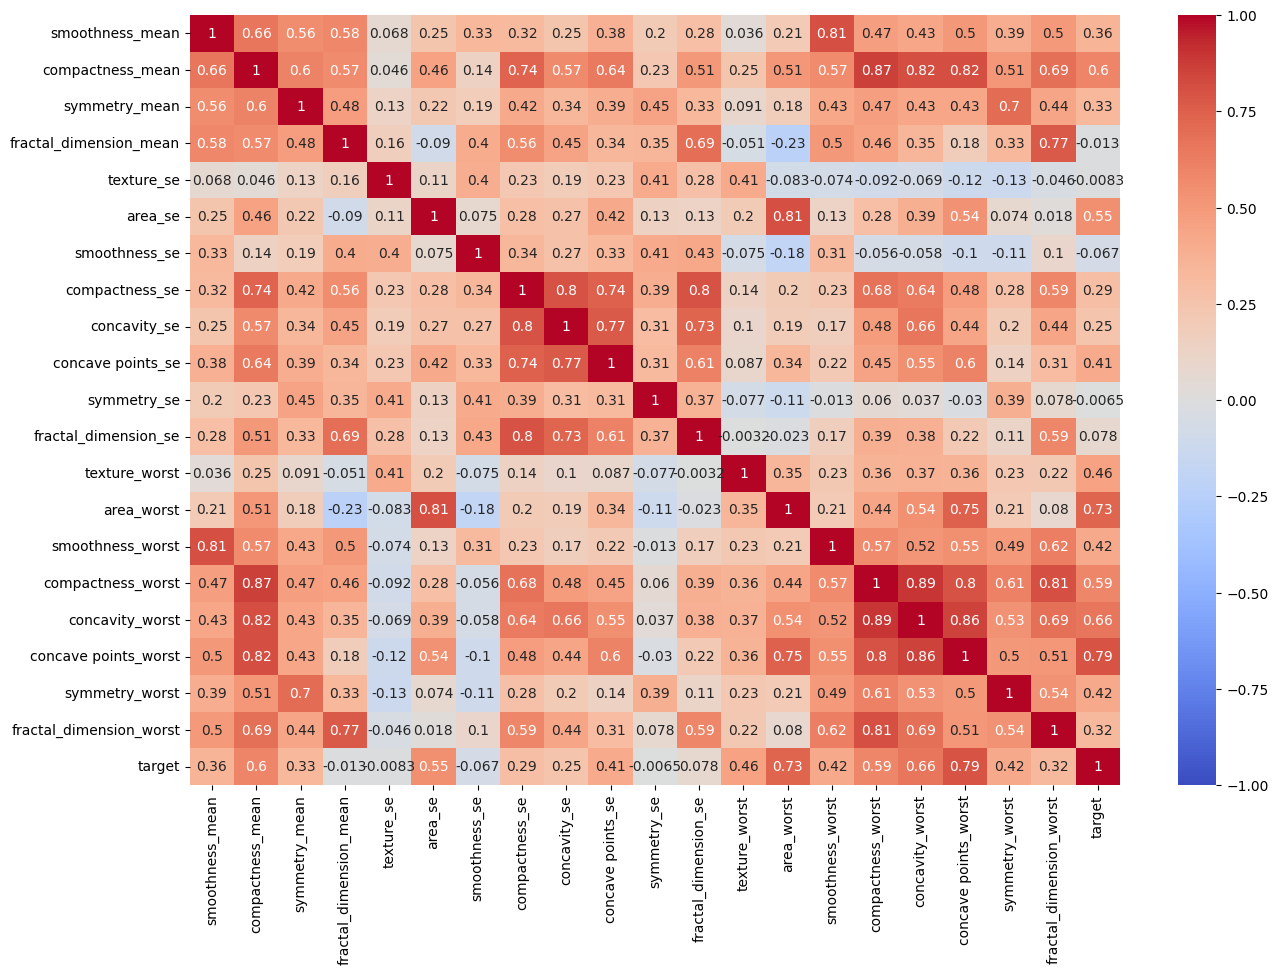

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(bcw_clean_df.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.show()

### Distribution of the variables with respect to the target variable

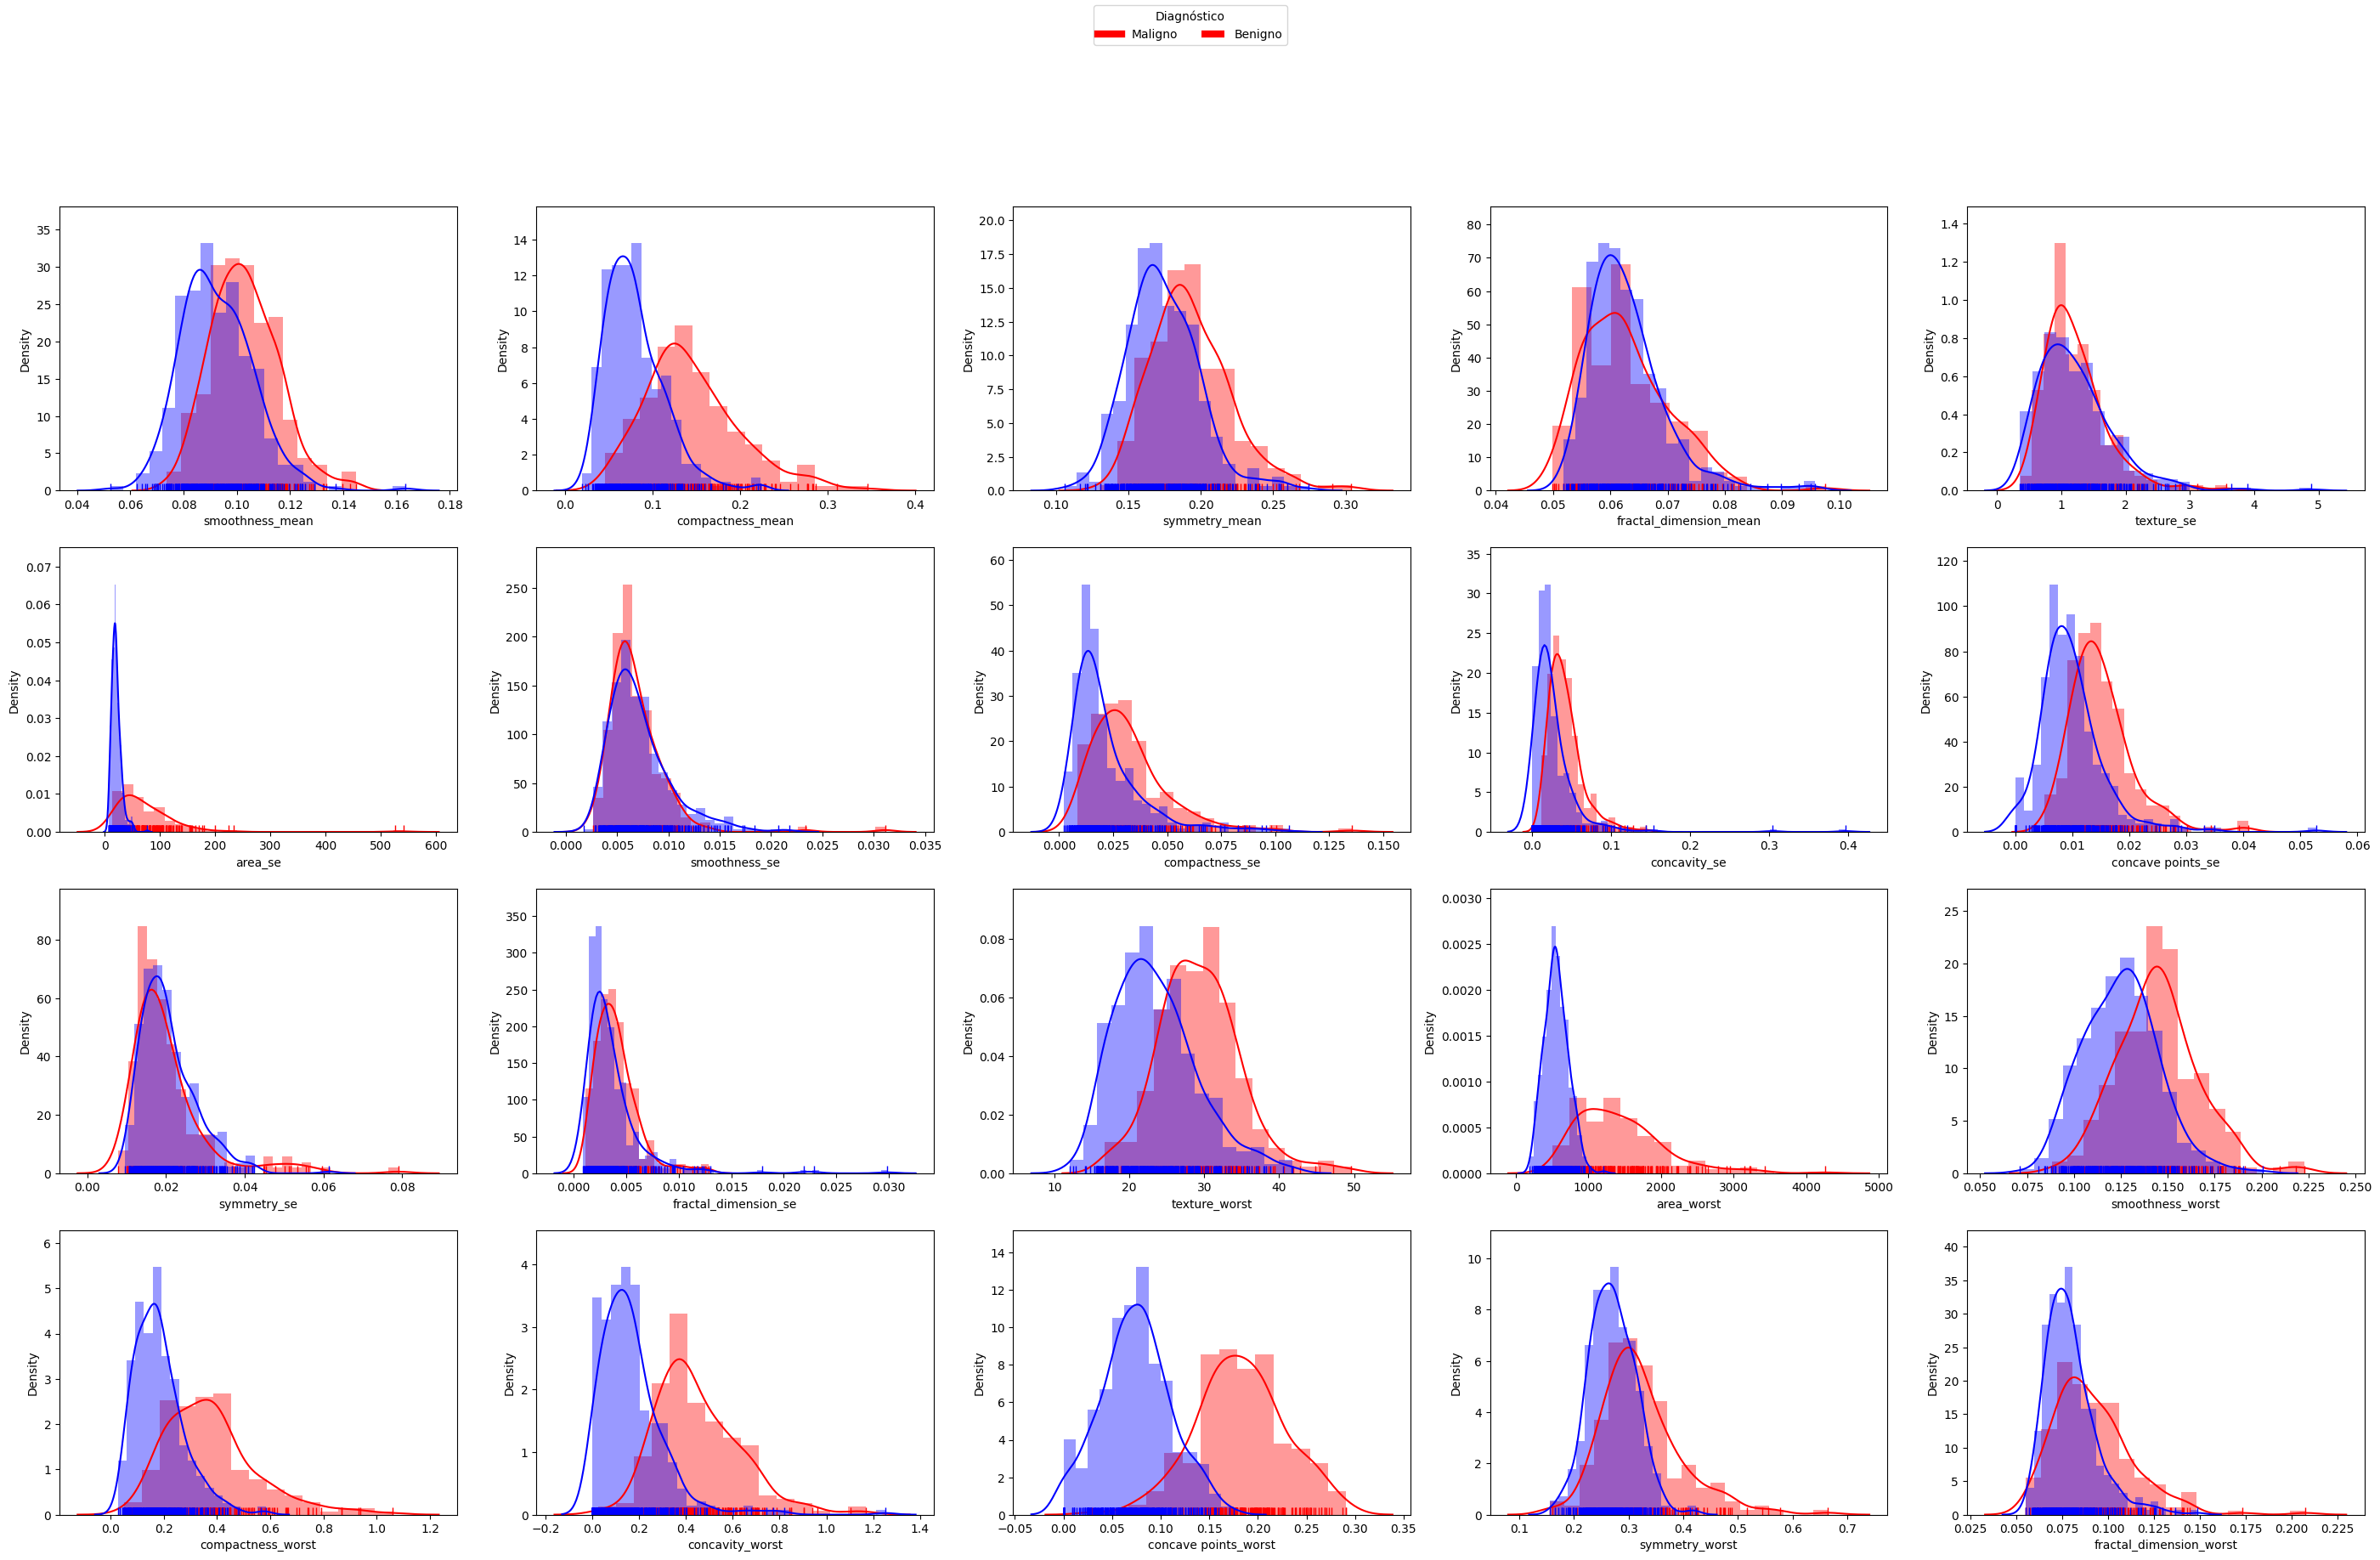

In [11]:
f, axes = plt.subplots(4, 5, figsize=(35, 20))
for c, ax in zip(bcw_clean_df.columns[:-1], axes.flatten()):
  line1 = sns.distplot(bcw_clean_df[bcw_clean_df.target == 1][c], rug=True, color='red', ax=ax)
  line2 = sns.distplot(bcw_clean_df[bcw_clean_df.target == 0][c], rug=True, color='blue', ax=ax)

# Mostramos una única leyenda para todos los subplots
leg = f.legend([line1, line2], labels=['Maligno', 'Benigno'],
        loc="upper center", ncol=2,
        title="Diagnóstico")
# Aumentamos el tamaño de las líneas de la leyenda.
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.show()

### Normalization

In [12]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler().fit(bcw_clean_df.iloc[:, :-1])
bcw_norm_df = std.transform(bcw_clean_df.iloc[:, :-1])
bcw_norm_df = pd.DataFrame(columns=bcw_clean_df.columns[:-1], data=bcw_norm_df)
bcw_norm_df['target'] = bcw_clean_df['target']

In [13]:

to_latex(bcw_norm_df.iloc[:6, [0, 1, 2, 3, -1]])

\begin{tabular}{rrrrr}
\toprule
 smoothness\_mean &  compactness\_mean &  symmetry\_mean &  fractal\_dimension\_mean &  target \\
\midrule
             1.6 &               3.3 &            2.2 &                     2.3 &       1 \\
            -0.8 &              -0.5 &            0.0 &                    -0.9 &       1 \\
             0.9 &               1.1 &            0.9 &                    -0.4 &       1 \\
             3.3 &               3.4 &            2.9 &                     4.9 &       1 \\
             0.3 &               0.5 &           -0.0 &                    -0.6 &       1 \\
             2.2 &               1.2 &            1.0 &                     1.9 &       1 \\
\bottomrule
\end{tabular}



### Principal Component Analysis (PCA)

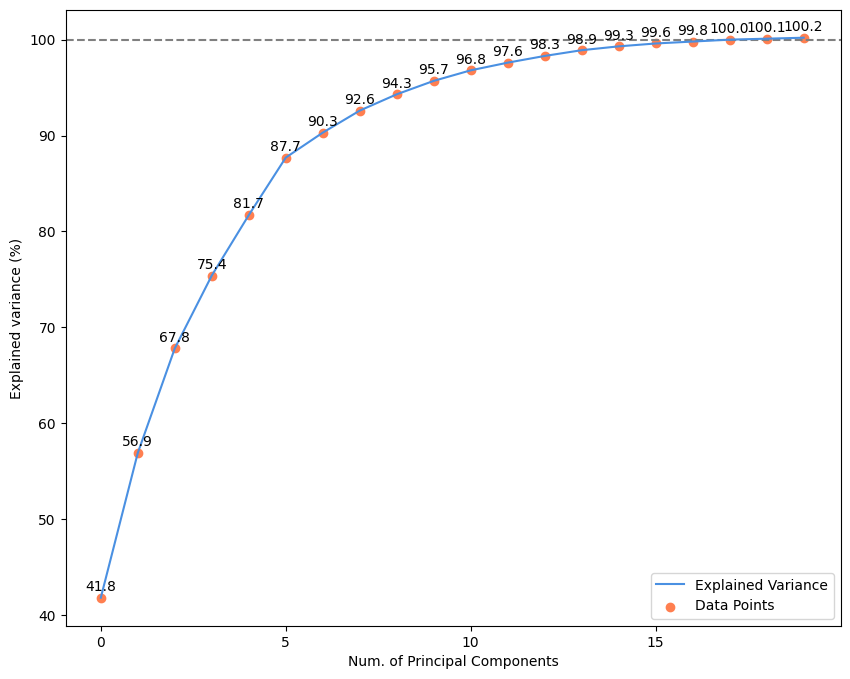

In [14]:
from sklearn.decomposition import PCA

X, y = bcw_norm_df.drop('target', axis=1), bcw_norm_df['target']
pca = PCA()
pca.fit(X)
explained_var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)


plt.figure(figsize=(10,8))
plt.axhline(100, linestyle='--', color='gray')
plt.plot(explained_var, color='#4A90E2', label='Explained Variance')
points = plt.scatter(range(len(explained_var)), explained_var, color='coral', label='Data Points')
for i, txt in enumerate(explained_var):
    plt.annotate(f"{txt:.1f}", (i, txt), textcoords="offset points", xytext=(0, 5), ha='center')
plt.xlabel('Num. of Principal Components')
plt.xticks(np.arange(0, 25, 5))
plt.yticks(np.arange(40, 110, 10))
plt.ylabel('Explained variance (%)')
plt.xticks(range(0, 20, 5))
plt.legend()
plt.show()

In [15]:
Xpca = pca.transform(X)[:, :10]
bcw_pca_df = pd.DataFrame(Xpca, columns=[f'PC {i+1}' for i in range(10)])
bcw_pca_df['target'] = y
bcw_pca_df

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9,PC 10,target
0,7.371777,-1.454434,-1.054312,-0.581842,1.706887,1.874750,1.942591,0.024492,-0.333130,-0.120956,1
1,-0.552629,-2.175279,0.913744,0.356532,0.909391,0.226683,0.440179,0.075212,0.842600,-0.018054,1
2,3.262606,-1.857634,0.576157,-0.360870,1.084510,0.838573,-0.363417,-0.056178,-0.058842,-0.442614,1
3,11.435339,2.494598,-5.455442,-1.532930,-1.004267,2.906304,1.248598,1.332217,-1.870350,0.283453,1
4,1.013867,-0.258889,1.602642,0.225341,2.708953,-0.580327,-0.453754,0.540373,0.507806,-0.018358,1
...,...,...,...,...,...,...,...,...,...,...,...
564,1.645574,-1.673853,3.178846,-0.639907,2.236324,-1.911861,-0.517567,-0.219214,0.493234,0.135374,1
565,0.159357,-1.374720,3.081404,-1.570707,-1.479631,-0.801078,-0.237062,-0.994071,-0.164076,0.269738,1
566,-0.209246,-1.116965,1.839553,1.334608,-0.853980,-0.713803,-0.458311,0.103889,0.125676,-0.444912,1
567,8.137511,-2.067645,-0.375820,-0.191313,-1.869425,0.079762,0.360794,-0.033917,-0.214609,-0.794341,1


Just for visualization, PC=2

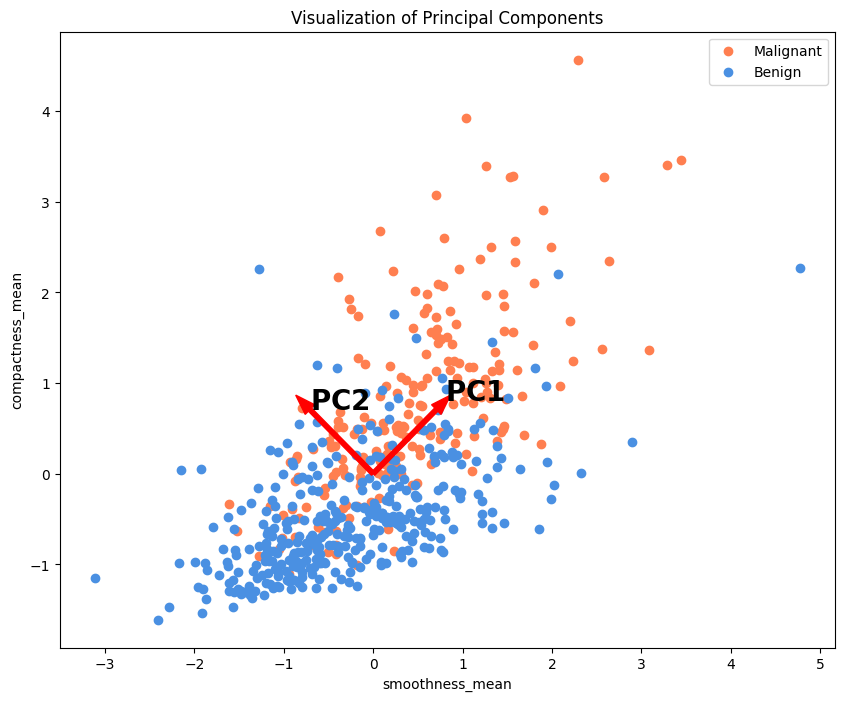

In [16]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform(X.iloc[:, [0,1]])

plt.figure(figsize=(10, 8))
plt.scatter(bcw_norm_df.loc[bcw_norm_df.target == 1].iloc[:, 0], bcw_norm_df.loc[bcw_norm_df.target == 1].iloc[:, 1], color='coral')
plt.scatter(bcw_norm_df.loc[bcw_norm_df.target == 0].iloc[:, 0], bcw_norm_df.loc[bcw_norm_df.target == 0].iloc[:, 1], color='#4A90E2')
plt.title('Visualization of Principal Components')
plt.legend(['Malignant', 'Benign'])
plt.arrow(0, 0, pca.components_[0,0], pca.components_[0,1], width=0.05, color='r')
plt.arrow(0, 0, pca.components_[1,0], pca.components_[1,1], width=0.05, color='r')
plt.annotate(r"$\bf{PC1}$",  pca.components_[0] + .1, fontsize=20,)
plt.annotate(r"$\bf{PC2}$",  pca.components_[1], fontsize=20,)
plt.xlabel('smoothness_mean')
plt.ylabel('compactness_mean')
plt.show()

### Let's take a peek at the target class...

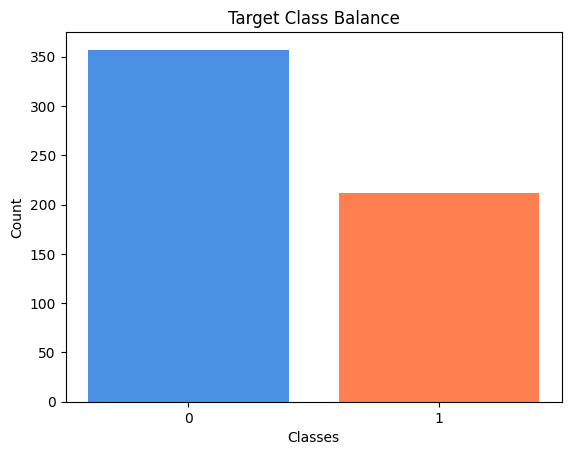

In [17]:
class_count = bcw_df['target'].value_counts()
plt.bar(class_count.index, class_count.values, color=['#4A90E2', 'coral'], label='Unbalanced Target Class')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Target Class Balance')
plt.xticks(class_count.index, [str(i) for i in class_count.index])
plt.show()

In [20]:
bcw_df.shape()

(569, 21)

## Data pipeline (finally)

In [21]:
from sklearn.pipeline import Pipeline

path_folder = '/content/drive/MyDrive/Datasets/SI_final_project'
PATH = os.path.join(path_folder, 'breast_cancer_wisconsin.csv')

bcw_df = pd.read_csv(PATH)
bcw_df = bcw_df.drop(['id', 'Unnamed: 32'], axis=1)
target, bcw_df = bcw_df['diagnosis'], bcw_df.drop('diagnosis', axis=1)
bcw_df['target'] = target
bcw_df['target'] = bcw_df['target'].apply(lambda x: {'M': 1, 'B': 0}.get(x))

bcw_df = correlation(bcw_df)
pipeline = Pipeline([
          ('Normalization', StandardScaler()),
          ('PCA', PCA(n_components=10))])

X, y = bcw_df.drop(['target'], axis=1), bcw_df['target']

bcw_pipeline_df = pipeline.fit_transform(X)
bcw_preproc_df = pd.DataFrame(bcw_pipeline_df, columns=[f'PC {i+1}' for i in range(10)])
bcw_preproc_df['target'] = y
path = os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'bcw_preproc.csv')
bcw_preproc_df.to_csv(path, index=False)

## Finally, we save train and test data

In [27]:
from sklearn.model_selection import train_test_split

X, y = bcw_preproc_df.drop(['target'], axis=1), bcw_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

bcw_test = pd.DataFrame(columns=X_test.columns, data=X_test)
bcw_test['target'] = y_test

bcw_train = pd.DataFrame(columns=X_train.columns, data=X_train)
bcw_train['target'] = y_train

path = os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'bcw_train.csv')
bcw_train.to_csv(path, index=False)
path = os.path.join('/content/drive/MyDrive/Datasets/SI_final_project', 'bcw_test.csv')
bcw_test.to_csv(path, index=False)

In [29]:
print(f'Train data shape: {bcw_train.shape}')
print(f'Test data shape: {bcw_test.shape}')

Train data shape: (381, 11)
Test data shape: (188, 11)
